# Statistical game result prediction
### Denisov Ilia

In [1]:
import numpy as np
import pylab as pl
from sklearn.metrics import f1_score, recall_score, accuracy_score, mean_squared_error, mean_absolute_error
import time

import matplotlib.patches as mpatches
import seaborn as sns

import ftplib
import pysftp
import pandas as pd
from datetime import datetime as dt
from collections import Counter
import matplotlib.mlab as mlab
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import pairwise_distances
import scipy as sp
import random
import scipy.stats
import os
import paramiko
from collections import defaultdict
pd.options.display.float_format = '{:.3f}'.format
np.set_printoptions(precision=2, threshold=5)
sns.set_style("whitegrid")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/denilv/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [150]:
def edit_csv(df_raw):
    df_raw = df_raw.fillna(0)
    df = df_raw.iloc[::2]
    delete_columns = ['week', 'game_id', 'season', 'team_org', 'opponent_team_org']
    df = df.drop(delete_columns, axis=1)
    
    dates = np.array(df.date)
    dates = [dt.strptime(str(i), '%Y%m%d').date() for i in dates]
    #add time
    times = []
    for i in df.time:
        splt = i.split(':')
        h = splt[0]
        m = splt[1]
        if i[-1] == 'p':
            h = str(12+int(h))
            if h == '24':
                h = '00'
            times.append(h + ':' + m[:-1])
        else:
            times.append(h + ':' + m[:-1])
    dts = [dt.strptime(str(d) + ' ' + t, '%Y-%m-%d %H:%M') for d,t in zip(dates, times)]

    #add week day
    weekdays = [i.weekday() for i in dates]

    #add weeknums
    weeknums = [i.isocalendar()[1] for i in dates]

    #add win/lose
    winloses = [1 if i>0 else 0 for i in df.points_difference]
    df.drop('win_against_spread', axis=1)

    #add seasons
    seasons = [i.year for i in dates]

    #add column season_week
    season_start = 40
    season_end = 24
    season_weeks = []
    for y, w in zip(seasons, weeknums):
        if w >= season_start:
            sw = w - 40
        else:
            sw = w - 40 + 53
        season_weeks.append(sw)
    df.head()

    season = []
    year = 2012
    prev_week = season_weeks[0]
    for sw in season_weeks:
        if sw < prev_week:
            year += 1
        season.append(year)
        prev_week = sw

    df.insert(4, 'start_dt', dts)
    df.insert(5, 'season', season)
    df.insert(6, 'season_week', season_weeks)
    df.insert(7, 'weekday', weekdays)
    df.insert(8, 'winlose', winloses)
        
    df.total_team = df.total_opponent
    delete_columns = ['date', 'time', 'win_against_spread', 'total_opponent']
    df = df.drop(delete_columns, axis=1)
    df = df.reset_index(drop=True)
    
    print('Dataframe length',len(df))
    return df
    

In [188]:
df_raw = pd.read_csv('seeds/inputs.csv')
df = edit_csv(df_raw)
df_old = df.copy()
df.head()

Dataframe length 5676


,team,opponent_team,start_dt,season,season_week,weekday,winlose,points,opponent_points,points_difference,spread,moneyline_team,moneyline_opponent,total_team,spread_percentage_sportsplays,spread_percentage_vegas,spread_percentage_sbr
0,DAL,WAS,2013-01-01 18:00:00,2012,14,1,1,103,94,9,-4.000,-170.000,160.000,191.500,72,82,65
1,POR,NYK,2013-01-01 19:30:00,2012,14,1,1,105,100,5,9.500,450.000,-525.000,197.000,40,44,45
2,SAC,DET,2013-01-01 19:30:00,2012,14,1,0,97,103,-6,7.000,240.000,-280.000,195.500,50,51,50
3,ATL,NOP,2013-01-01 20:00:00,2012,14,1,1,95,86,9,-2.000,-120.000,110.000,185.000,83,50,60
4,LAC,DEN,2013-01-01 21:00:00,2012,14,1,0,78,92,-14,1.000,-105.000,-105.000,207.500,65,50,51


In [189]:
distance_features = ['season_week', 'spread', 'spread_percentage_sbr', 'moneyline_team',\
       'moneyline_opponent', \
       'spread_percentage_sportsplays',]# 'spread_percentage_vegas']
for column in distance_features:
    for perc in (1, 5, 50, 75, 90, 95, 99):
        val = np.percentile(np.abs(df[column]), perc)
        print('{: >2d} percintile is {: >5.1f} for {} column.'.format(perc, val, column.upper()))
    print()

 1 percintile is   1.0 for SEASON_WEEK column.
 5 percintile is   3.0 for SEASON_WEEK column.
50 percintile is  16.0 for SEASON_WEEK column.
75 percintile is  24.0 for SEASON_WEEK column.
90 percintile is  28.0 for SEASON_WEEK column.
95 percintile is  30.0 for SEASON_WEEK column.
99 percintile is  34.0 for SEASON_WEEK column.

 1 percintile is   1.0 for SPREAD column.
 5 percintile is   1.5 for SPREAD column.
50 percintile is   5.5 for SPREAD column.
75 percintile is   8.5 for SPREAD column.
90 percintile is  11.5 for SPREAD column.
95 percintile is  13.5 for SPREAD column.
99 percintile is  16.5 for SPREAD column.

 1 percintile is  36.0 for SPREAD_PERCENTAGE_SBR column.
 5 percintile is  41.0 for SPREAD_PERCENTAGE_SBR column.
50 percintile is  51.0 for SPREAD_PERCENTAGE_SBR column.
75 percintile is  56.0 for SPREAD_PERCENTAGE_SBR column.
90 percintile is  61.0 for SPREAD_PERCENTAGE_SBR column.
95 percintile is  63.0 for SPREAD_PERCENTAGE_SBR column.
99 percintile is  66.0 for SPREAD

### Some features reforms

In [190]:
#cut by percentile
df = df_old.copy()
perc = 95
for column in ('moneyline_opponent', 'moneyline_team'):
    val = np.percentile(np.abs(df[column]), perc)
    df = df[np.abs(df[column]) < val]
print("Deleted {} rows".format(len(df_old) - len(df)))


Deleted 572 rows


In [191]:
tmp = len(df)
for column in ('moneyline_team', 'moneyline_opponent'):
    df = df[np.abs(df[column]) != 0]
print("Deleted {} rows".format(tmp - len(df)))

Deleted 45 rows


In [192]:
# season_start = 40
# season_end = 24
# tmp = len(df)
# df = df[np.logical_or(df.week >= season_start, df.week <= season_end)]
# print("Deleted {} rows".format(tmp - len(df)))


## Find of the most correlated features

In [193]:
def find_correlated_features(x, features):
    # replace this code to find really correlated features
    corr_matrix = abs(np.corrcoef(x.T))
    c = Counter()
    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
            c['{} + {}'.format(feature_i, feature_j)] =  corr_matrix[i,j]
            if i < j and  corr_matrix[i,j] > 0.3:
                print("Correlated features: %s + %s -> %.2f" % (feature_i, feature_j, corr_matrix[i,j]))
#     print(c.most_common(20))

In [194]:
df.columns

Index(['team', 'opponent_team', 'start_dt', 'season', 'season_week', 'weekday',
       'winlose', 'points', 'opponent_points', 'points_difference', 'spread',
       'moneyline_team', 'moneyline_opponent', 'total_team',
       'spread_percentage_sportsplays', 'spread_percentage_vegas',
       'spread_percentage_sbr'],
      dtype='object')

In [195]:
features = ['season', 'season_week', 'weekday', 'winlose',\
            'points', 'opponent_points', 'points_difference',\
            'spread', 'spread_percentage_sbr', 'moneyline_team',\
            'moneyline_opponent', 'total_team',\
            'spread_percentage_sportsplays', 'spread_percentage_vegas']
x = df[features].values

In [196]:
find_correlated_features(x, features)

Correlated features: season + season_week -> 0.41
Correlated features: season + total_team -> 0.32
Correlated features: winlose + points -> 0.44
Correlated features: winlose + opponent_points -> 0.41
Correlated features: winlose + points_difference -> 0.81
Correlated features: winlose + spread -> 0.35
Correlated features: winlose + moneyline_team -> 0.35
Correlated features: winlose + moneyline_opponent -> 0.35
Correlated features: points + opponent_points -> 0.44
Correlated features: points + points_difference -> 0.54
Correlated features: points + total_team -> 0.38
Correlated features: opponent_points + points_difference -> 0.53
Correlated features: opponent_points + total_team -> 0.39
Correlated features: points_difference + spread -> 0.40
Correlated features: points_difference + moneyline_team -> 0.39
Correlated features: points_difference + moneyline_opponent -> 0.39
Correlated features: spread + spread_percentage_sbr -> 0.46
Correlated features: spread + moneyline_team -> 0.99
Co

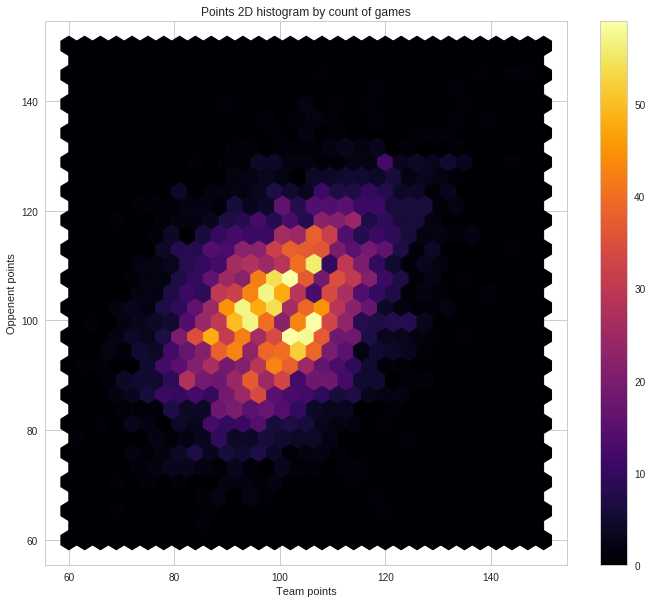

In [197]:
pl.figure(figsize=[11.7,10])
hb = pl.hexbin(df['points'], df['opponent_points'], gridsize=30, cmap='inferno', extent=[60, 150, 60, 150])
pl.xlabel('Team points')
pl.ylabel('Oppenent points')
pl.title('Points 2D histogram by count of games')
pl.colorbar()
pl.show()

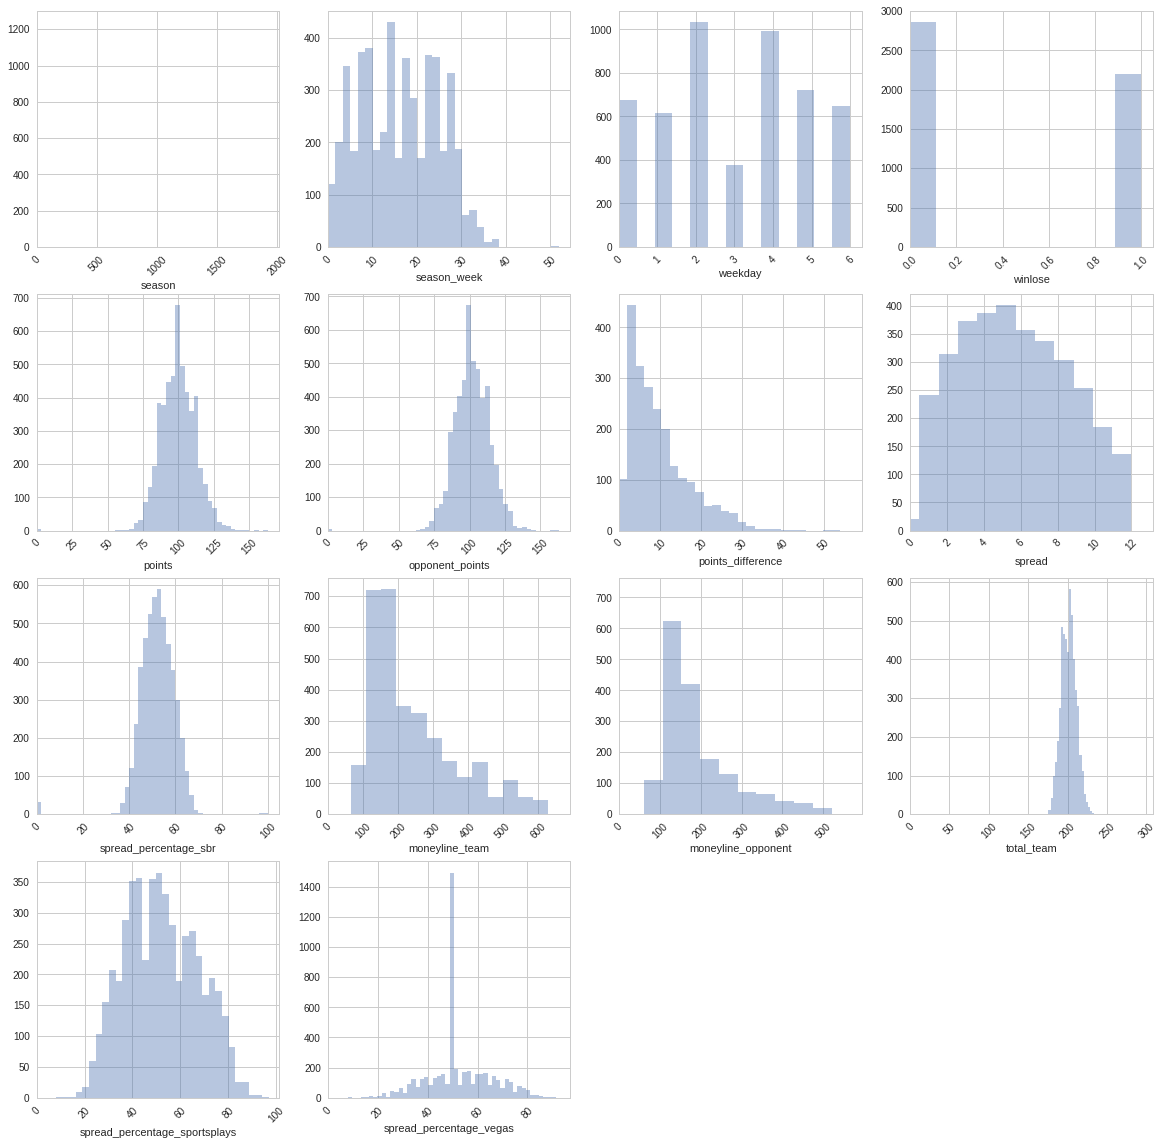

In [198]:
for i, f in enumerate(features):
    plt.subplot(4, 4,i+1)
    fig = plt.gcf()
    fig.set_size_inches(20,20)
    sns.distplot(df[f], kde=False)
    plt.xlim(0)
    plt.xticks(rotation=45)
plt.show()

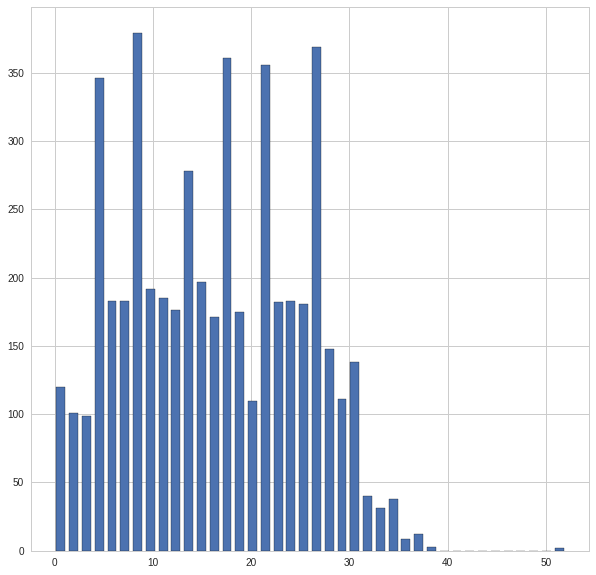

In [199]:
season_week = np.array(df['season_week'])
pl.figure(figsize=[10,10])
n, bins, patches = pl.hist(season_week, bins=len(set(df.season_week)), edgecolor='black', rwidth=0.7)
pl.grid(True)
pl.show()

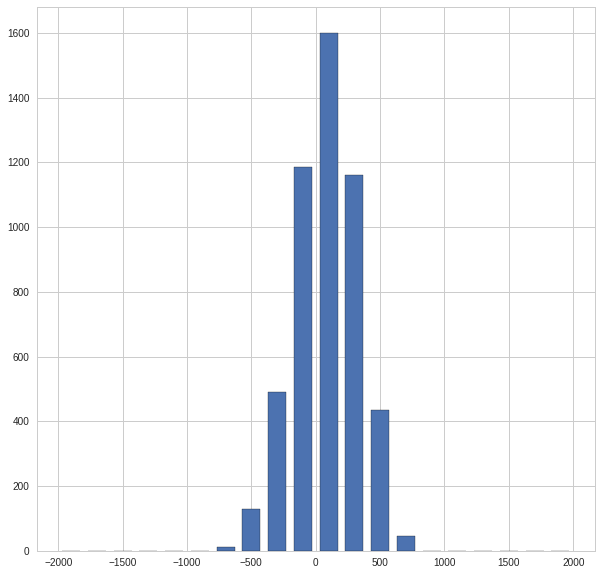

In [142]:
moneyline_team = np.array(df['moneyline_team'])
pl.figure(figsize=[10,10])
n, bins, patches = pl.hist(moneyline_team, bins=20, edgecolor='black', rwidth=0.7, range=(-2000, 2000))
pl.grid(True)
pl.show()

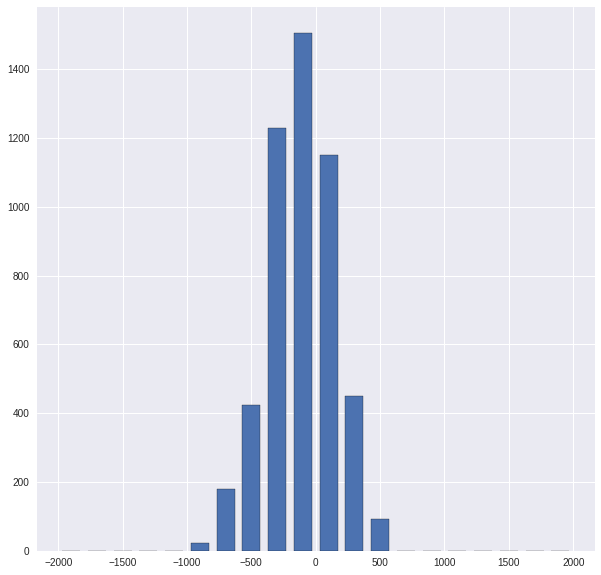

In [18]:
moneyline_opponent = np.array(df['moneyline_opponent'])
pl.figure(figsize=[10,10])
n, bins, patches = pl.hist(moneyline_opponent, bins=20, edgecolor='black', rwidth=0.7, range=(-2000, 2000))
pl.grid(True)
pl.show()

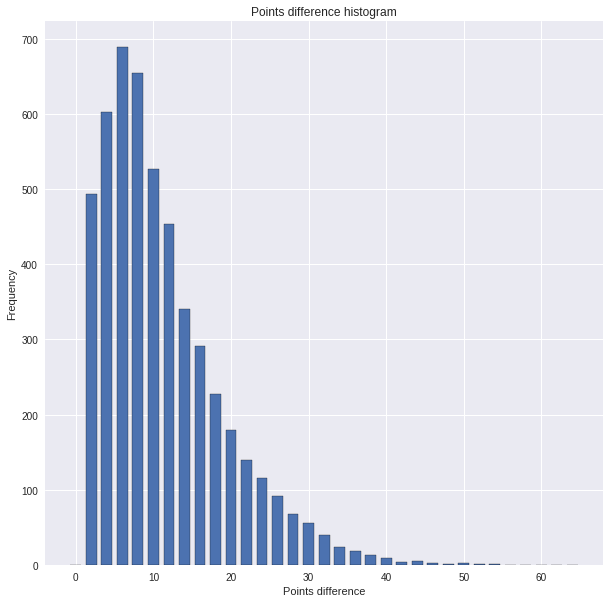

In [20]:
pts_diff = np.array(df['points_difference'])
pts_diff = np.abs(pts_diff)[pts_diff!=0]
pl.figure(figsize=[10,10])
n, bins, patches = pl.hist(pts_diff, bins=33, edgecolor='black', range=(-1, 65), rwidth=0.7)
pl.title('Points difference histogram')
pl.xlabel('Points difference')
pl.ylabel('Frequency')
# pl.xticks(range(-70,70,2))
pl.grid(True)
pl.show()

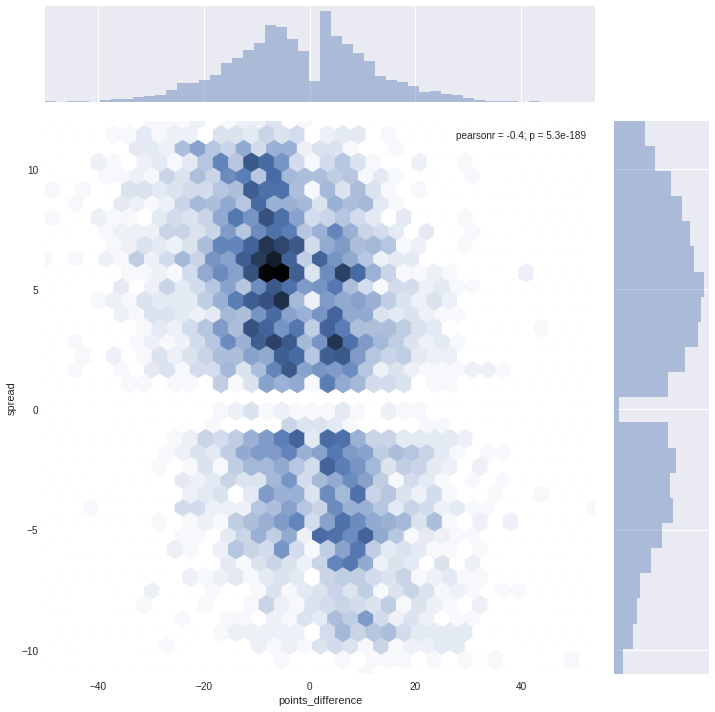

In [21]:
x = df.points_difference
y = df.spread
sns.jointplot(x=x, y=y, kind='hex', size=10)
pl.show()

## Get most similiar games

In [116]:
def generate_report(_id):
    w_av =np.average(similar_games[_id].points_difference[1:], weights=similar_games[_id].distance[1:])
    print('Weighted average points_difference for simillar games', w_av)
    print('Average points_difference for simillar games', \
          np.average(similar_games[_id].points_difference[1:]))
    pl.figure(figsize=[10,10])
    x = df.points_difference
    y = df.spread
    pl.scatter(x, y, c='lightblue', s=5, )
    
    top = 20
    x1 = similar_games[_id].points_difference
    y1 = similar_games[_id].spread
    pl.scatter(x1[:top], y1[:top], c='red', s=10)
    plt.xlim(-50,  40)
    plt.ylim(-20, 30)
    pl.xlabel('Points difference')
    pl.ylabel('Spred')
    pl.title('Show on the scatter the nearest games to the given game of 2017 season NCAA Basketball (id {})'.format(_id))
    pl.show()
    return w_av

In [115]:
distance_features = ['season_week', 'spread', 'spread_percentage_sbr', 'moneyline_team',\
       'moneyline_opponent', 'spread_percentage_sportsplays']

def get_similar_games(games, games_history, metric='euclidean', top=1000):
    scaler = MinMaxScaler()
    scaled_history = scaler.fit_transform(np.array(games_history[distance_features].values))
    scaled_games = scaler.transform(games[distance_features].values)
    dists = pairwise_distances(scaled_games, scaled_history, metric=metric, n_jobs=4)
    result = []
    for d in dists:
        args = d.argsort()
        similar_games = games_history.iloc[args[:top]]
        similar_games.insert(0, 'distance', d[args[:top]])
#         similar_games = similar_games[similar_games.distance > 0.001]
        result.append(similar_games)
    return result

In [117]:
def get_pds(games, similar_games, top=100, weighted=True):
    games_history = df[features].values
    pds = []
    for game, sim_games in zip(games.itertuples(), similar_games):
        tmp = sim_games[np.logical_or(sim_games.year < game.year,\
                                       sim_games.week < game.week)]
        tmp = tmp[tmp.distance > 0.0001]
        if weighted:
    #             print(tmp.distance[:top])
            av_pd = np.average(tmp.points_difference[:top], weights=tmp.distance[:top])
        else:
            av_pd = np.average(tmp.points_difference[:top])
        pds.append(av_pd)
    return pds

def get_pds_by_distance(games, similar_games, distance=0.5, weighted=True):
    games_history = df[features].values
    pds = []
    for game, sim_games in zip(games.itertuples(), similar_games):
        tmp = sim_games[np.logical_or(sim_games.year < game.year,\
                                       sim_games.week < game.week)]
        tmp = tmp[tmp.distance > 0.0001]
        if len(tmp[tmp.distance < distance]) == 0:
            print('No games with distance LE {}. Using top 10 games'.format(distance))
            tmp = tmp[:10]
        if weighted:
            av_pd = np.average(tmp.points_difference, weights=tmp.distance)
        else:
            av_pd = np.average(tmp.points_difference)
        pds.append(av_pd)
    return pds


In [118]:
def get_scores(games, pds):
    winpred = [1 if i > 0 else 0 for i in pds]
    wintest = [1 if i > 0 else 0 for i in games.points_difference]
    acc = accuracy_score(wintest, winpred)
    rec = recall_score(wintest, winpred)
    f1 = f1_score(wintest, winpred)
    mse = mean_squared_error(games.points_difference, pds)
    mae = mean_absolute_error(games.points_difference, pds)
#     print('Accuracy score {:.5f}'.format(acc))
#     print('MSE      score {:.5f}'.format(mse))
#     print('MAE      score {:.5f}'.format(mae))
    return acc, mse, mae

In [57]:
'''
Valid values for metric are:
From scikit-learn: 
[‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’]. 
These metrics support sparse matrix inputs.
From scipy.spatial.distance: 
[‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, \
‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘matching’,  \
‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’,     \
‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’] 
See the documentation for scipy.spatial.distance for details on these metrics. 
These metrics do not support sparse matrix inputs.

'''
#METRIC to SEASON to TOP to SCORE
msts = {} #defaultdict(lambda : defaultdict(lambda : defaultdict({})))
metrics = ('cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan')
for metric in metrics:
    msts[metric] = {}
    print('Using {} metric'.format(metric))
    for season in (2014, 2015, 2016):
        msts[metric][season] = {}
        games = df[df.season == season]
        history = df[[i in games.index for i in df.index]]
        similar_games = get_similar_games(games, df, metric=metric)
        print('Season {}, {} games'.format(season, len(games)))
        tops = list(range(5, 125, 5))
        for top in tops:
            msts[metric][season][top] = {}
            print('Using top {} games'.format(top))
            pds = get_pds_by_top(games, similar_games, top=top)
            acc, mse, mae = get_scores(games, pds)
            msts[metric][season][top]['acc'] = acc
            msts[metric][season][top]['mse'] = mse
            msts[metric][season][top]['mae'] = mae
            print('-'*100)
        print('-'*100)

    # print(winlose)

Using cityblock metric
Season 2014, 1240 games
Using top 5 games
----------------------------------------------------------------------------------------------------
Using top 10 games
----------------------------------------------------------------------------------------------------
Using top 15 games
----------------------------------------------------------------------------------------------------
Using top 20 games
----------------------------------------------------------------------------------------------------
Using top 25 games
----------------------------------------------------------------------------------------------------
Using top 30 games
----------------------------------------------------------------------------------------------------
Using top 35 games
----------------------------------------------------------------------------------------------------
Using top 40 games
-----------------------------------------------------------------------------------------------

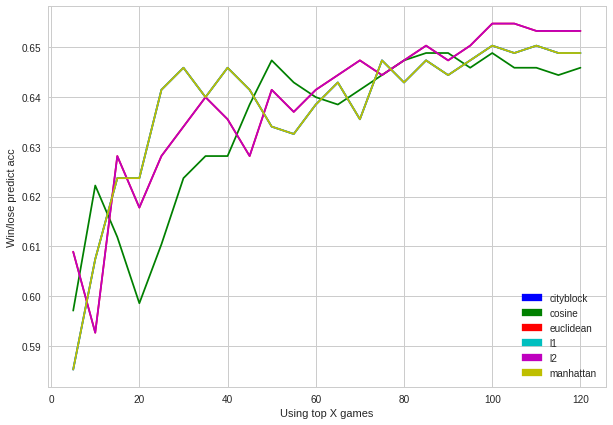

In [240]:
pl.figure(figsize=(10,7))
# metrics = ('cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan')
patches = []
colors = 'bgrcmykw'
score_func = 'acc'
season = 2016
for metric, color in zip(metrics, colors):
    patches.append(mpatches.Patch(color=color, label=metric))
    scores = [ msts[metric][season][top][score_func] for top in tops]
    pl.plot(list(msts[metric][season].keys()), scores, c=color)
pl.xlabel('Using top X games')
pl.ylabel('Win/lose predict {}'.format(score_func))
plt.legend(handles=patches, loc=4)
pl.show()

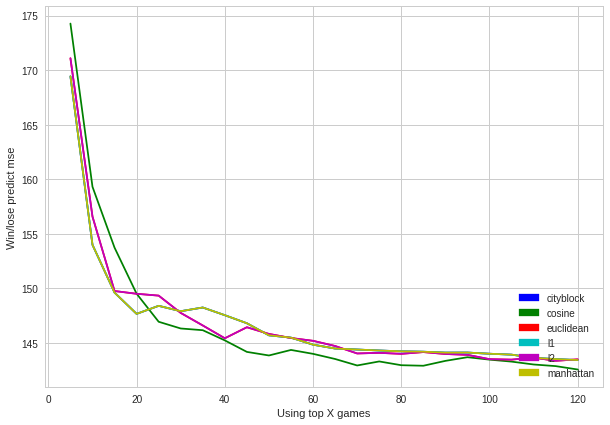

In [59]:
pl.figure(figsize=(10,7))
# metrics = ('cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan')
patches = []
colors = 'bgrcmykw'
score_func = 'mse'
season = 2015
for metric, color in zip(metrics, colors):
    patches.append(mpatches.Patch(color=color, label=metric))
    scores = [ msts[metric][season][top][score_func] for top in tops]
    pl.plot(list(msts[metric][season].keys()), scores, c=color)
pl.xlabel('Using top X games')
pl.ylabel('Win/lose predict {}'.format(score_func))
plt.legend(handles=patches, loc=4)
pl.show()

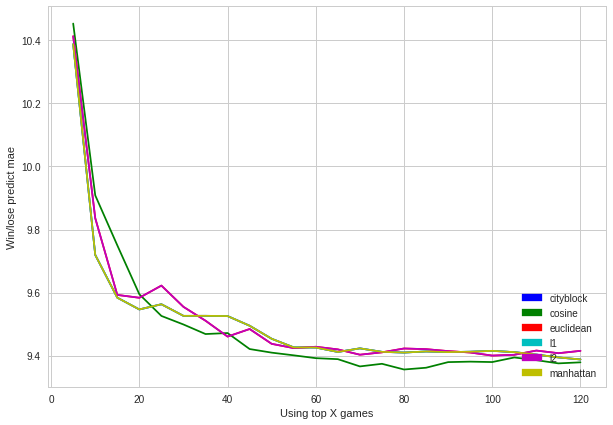

In [60]:
pl.figure(figsize=(10,7))
# metrics = ('cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan')
patches = []
colors = 'bgrcmykw'
score_func = 'mae'
season = 2015
for metric, color in zip(metrics, colors):
    patches.append(mpatches.Patch(color=color, label=metric))
    scores = [ msts[metric][season][top][score_func] for top in tops]
    pl.plot(list(msts[metric][season].keys()), scores, c=color)
pl.xlabel('Using top X games')
pl.ylabel('Win/lose predict {}'.format(score_func))
plt.legend(handles=patches, loc=4)
pl.show()

## Look at N previous games

In [217]:
team = 'BOS'
home_games = df[df.team == team]
home_games.head()

,team,opponent_team,start_dt,season,season_week,weekday,winlose,points,opponent_points,points_difference,spread,moneyline_team,moneyline_opponent,total_team,spread_percentage_sportsplays,spread_percentage_vegas,spread_percentage_sbr
33,BOS,ATL,2013-01-05 19:00:00,2012,14,5,1,89,81,8,5.500,190.000,-210.000,187.000,56,34,50
47,BOS,NYK,2013-01-07 19:30:00,2012,15,0,1,102,96,6,7.500,290.000,-320.000,191.500,39,32,42
136,BOS,DET,2013-01-20 19:30:00,2012,16,6,0,88,103,-15,-2.000,-120.000,110.000,184.000,74,79,60
147,BOS,CLE,2013-01-22 19:00:00,2012,17,1,0,90,95,-5,-5.000,-190.000,175.000,190.000,74,71,55
162,BOS,ATL,2013-01-25 19:30:00,2012,17,4,0,111,123,-12,5.500,180.000,-220.000,185.000,64,62,56


In [274]:
def get_last_games(team, opp, period=None, until=dt.now(), N=None):
    team = team.upper()
    opp = opp.upper()
    games = df
    
    if team != 'ANY':
        games = games[games.team == team]
    if opp != 'ANY':
        games = games[games.opponent_team == opp]
#     games = df[np.logical_or(df.team == team, df.opponent_team == team)]
    
    if period is not None:
        since = until - datetime.timedelta(days=period)
        games = games[np.logical_and(games.start_dt >= since, games.start_dt < until)]
    if N is not None:
        games = games[-N:]
    return games

In [322]:
def get_form(game):
    team = game.team
    opp = game.opponent_team
    until = game.start_dt
    d = {}
    d['dir'] = {}
    d['inv'] = {}
    
    periods = (3, 7, 21, 60, 180, 360, 540)
    for period in periods:

        #windloss pd h_p a_p
        dir_games = get_last_games(team, opp, until=game.start_dt, period=period)
        inv_games = get_last_games(opp, team, until=game.start_dt, period=period)


        d['dir'][period] = {}
        d['inv'][period] = {}
        d['dir'][period]['winlose'] = np.sum(dir_games.winlose)
        d['dir'][period]['pd'] = np.sum(dir_games.points_difference)
        d['dir'][period]['points'] = np.sum(dir_games.points)
        d['dir'][period]['opp_points'] = np.sum(dir_games.opponent_points)
        d['dir'][period]['n_games'] = len(dir_games)
        
        
        d['inv'][period]['winlose'] = np.sum(inv_games.winlose)
        d['inv'][period]['pd'] = np.sum(inv_games.points_difference)
        d['inv'][period]['points'] = np.sum(inv_games.points)
        d['inv'][period]['opp_points'] = np.sum(inv_games.opponent_points)
        d['inv'][period]['n_games'] = len(inv_games)

#         d[period]['dir_winlose'] = np.sum(dir_games.winlose)
#         d[period]['dir_pd'] = np.sum(dir_games.points_difference)
#         d[period]['dir_points'] = np.sum(dir_games.points)
#         d[period]['dir_opp_points'] = np.sum(dir_games.opponent_points)
#         d[period]['dir_n_games'] = len(dir_games)
        
        
#         d[period]['inv_winlose'] = np.sum(inv_games.winlose)
#         d[period]['inv_pd'] = np.sum(inv_games.points_difference)
#         d[period]['inv_points'] = np.sum(inv_games.points)
#         d[period]['inv_opp_points'] = np.sum(inv_games.opponent_points)
#         d[period]['inv_n_games'] = len(dir_games)
        
    return d
        

In [329]:
pd.DataFrame(df.loc[4916])

,4916
team,OKC
opponent_team,GSW
start_dt,2016-05-30 20:00:00
season,2015
season_week,35
weekday,0
winlose,0
points,88
opponent_points,96
points_difference,-8


In [324]:
pd.DataFrame(get_form(df.loc[4916])['dir'])

,3,7,21,60,180,360,540
n_games,0,1,3,3,5,5,7
opp_points,0,120,340,340,577,577,808
pd,0,-9,-30,-30,-53,-53,-84
points,0,111,310,310,524,524,724
winlose,0,0,1,1,1,1,1


In [325]:
pd.DataFrame(get_form(df.loc[4916])['inv'])

,3,7,21,60,180,360,540
n_games,1,2,3,3,4,4,5
opp_points,101,219,352,352,470,470,597
pd,7,-17,-45,-45,-42,-42,-54
points,108,202,307,307,428,428,543
winlose,1,1,1,1,2,2,2


In [296]:
df[df.start_dt > (dt.now() - datetime.timedelta(days=360))]

,team,opponent_team,start_dt,season,season_week,weekday,winlose,points,opponent_points,points_difference,spread,moneyline_team,moneyline_opponent,total_team,spread_percentage_sportsplays,spread_percentage_vegas,spread_percentage_sbr
4895,SAS,OKC,2016-05-08 19:00:00,2015,31,6,0,97,111,-14,2.000,110.000,-130.000,199.000,56,50,52
4896,TOR,MIA,2016-05-09 19:00:00,2015,32,0,0,87,94,-7,4.500,175.000,-210.000,194.000,50,48,48
4897,GSW,POR,2016-05-09 21:30:00,2015,32,0,1,132,125,7,-6.500,-275.000,235.000,215.000,67,68,58
4898,OKC,SAS,2016-05-10 19:00:00,2015,32,1,1,95,91,4,7.000,275.000,-335.000,199.000,43,51,47
4899,MIA,TOR,2016-05-11 19:00:00,2015,32,2,0,91,99,-8,5.000,175.000,-210.000,189.000,54,48,55
4901,SAS,OKC,2016-05-12 19:30:00,2015,32,3,0,99,113,-14,0.000,-105.000,-105.000,198.000,55,52,53
4902,TOR,MIA,2016-05-13 19:00:00,2015,32,4,0,91,103,-12,3.500,150.000,-170.000,188.000,53,50,53
4903,MIA,TOR,2016-05-15 14:30:00,2015,32,6,0,89,116,-27,4.500,165.000,-190.000,188.500,65,64,57
4904,OKC,GSW,2016-05-16 20:00:00,2015,33,0,1,108,102,6,7.500,320.000,-390.000,225.000,46,46,50
4906,OKC,GSW,2016-05-18 20:00:00,2015,33,2,0,91,118,-27,9.000,375.000,-470.000,223.000,46,38,50


## Predict new games

In [31]:
def edit_csv_v2(df):
    df = df.fillna(0)

    dates = np.array(df.date)
    dates = [dt.strptime(str(i), '%Y%m%d').date() for i in dates]
    #add time
    hours = []
    for i in df.time:
        if i[-1] == 'p':
            hours.append(12+int(i.split(':')[0]))
        else:
            hours.append(int(i.split(':')[0]))
    df.insert(1, 'hour', hours)

    #add week day
    weekdays = [i.weekday() for i in dates]
    df.insert(1, 'weekday', weekdays)

    #add weeknums
    weeknums = [i.isocalendar()[1] for i in dates]
    df.insert(1, 'week', weeknums)

    #add win/lose
    winloses = [1 if i>0 else 0 for i in df.points_difference]
    df.insert(1, 'winlose', winloses)
    df.drop('win_against_spread', axis=1)

    #add seasons
    seasons = [i.year for i in dates]
    df.insert(1, 'year', seasons)

    #add column season_week
    season_start = 40
    season_end = 24
    season_week = []
    for y, w in zip(df.year, df.week):
        if w >= season_start:
            sw = w - 40
        else:
            sw = w - 40 + 53
        season_week.append(sw)
    df.insert(0, 'season_week', season_week)
    df.head()

    season = []
    year = 2016
    for sw in df.season_week:
        season.append(year)
    df.insert(0, 'season', season)

    df.total_team = df.total_opponent
    delete_columns = ['date', 'time', 'win_against_spread', 'total_opponent']
    df = df.drop(delete_columns, axis=1)
#     df = df.reset_index(drop=True)
    print('Dataframe length',len(df))
    return df
    

In [231]:
def prepare_predict(games):
    similar_games = get_similar_games(games, df)
    pds = get_pds(games, similar_games)
    games.insert(0, 'distance', 0.0)
#     print(pds, len(games), len(similar_games))
    games['points_difference'] = pds
    for i in range(len(games)):
        tmp = pd.DataFrame(games.iloc[i]).T
        similar_games[i] = pd.concat([tmp, similar_games[i]], axis=0)
    for sg in similar_games:
        t = sg.iloc[0].team
        op = sg.iloc[0].opponent_team
        dt = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M')
        path = '/home/denilv/denilvovich@gmail.com/predictions/{}_{}-{}.csv'.format(dt, t, op)
        sg = sg[['distance', 'team', 'opponent_team', 'points_difference', 'points', 'opponent_points',\
                 'season', 'season_week', 'year', 'week', 'weekday', 'spread', 'total_team',\
                 'spread_percentage_sbr', 'spread_percentage_sportsplays', 'spread_percentage_vegas',]]
        sg.to_csv(path, index=False)
    return similar_games

In [199]:
def preprocess_dataframe(new_df):    
    new_df = new_df.drop(['timestamp', 'spread_percentage_sbr_opp', \
                          'spread_percentage_sportsplays_opp', \
                          'spread_percentage_vegas_opp', 'spread_sbr_opp'], axis=1)

    new_df = new_df.rename(columns={'spread_percentage_sbr_team':'spread_percentage_sbr',\
                                    'spread_percentage_sportsplays_team':'spread_percentage_sportsplays',\
                                    'spread_percentage_vegas_team':'spread_percentage_vegas',\
                                    'moneyline_opp':'moneyline_opponent',
                                    'spread_sbr_team':'spread', \
                                    'opp_team':'opponent_team'})
    
    dates = np.array(new_df.date)
    dates = [dt.strptime(str(i), '%Y%m%d').date() for i in dates]
    #add time
    hours = []
    for i in new_df.time:
        if i[-1] == 'p':
            hours.append(12+int(i.split(':')[0]))
        else:
            hours.append(int(i.split(':')[0]))
    new_df.insert(1, 'hour', hours)

    #add week day
    weekdays = [i.weekday() for i in dates]
    new_df.insert(1, 'weekday', weekdays)

    #add weeknums
    weeknums = [i.isocalendar()[1] for i in dates]
    new_df.insert(1, 'week', weeknums)

    #add seasons
    seasons = [i.year for i in dates]
    new_df.insert(1, 'year', seasons)

    #add column season_week
    season_start = 40
    season_end = 24
    season_week = []
    for y, w in zip(new_df.year, new_df.week):
        if w >= season_start:
            sw = w - 40
        else:
            sw = w - 40 + 53
        season_week.append(sw)
    new_df.insert(0, 'season_week', season_week)

    new_df.insert(0, 'season', [2016]*len(new_df))

    new_df = new_df.drop(['date', 'time', 'total_opp'], axis=1)
    new_cols = ['team', 'opponent_team', 'season', 'season_week', 'year', 'week', 'weekday', 'hour', 'spread', \
                'moneyline_team', 'moneyline_opponent', 'total_team', 'spread_percentage_sbr', \
                'spread_percentage_sportsplays', 'spread_percentage_vegas']
    new_df = new_df[new_cols]
    new_spread_percentage_sbr = [i.split()[-1][:-1] for i in new_df.spread_percentage_sbr]
    new_df.spread_percentage_sbr = new_spread_percentage_sbr

    new_moneyline_team = [i.split()[0] for i in new_df.moneyline_team]
    new_df.moneyline_team = new_moneyline_team

    new_moneyline_opponent = [i.split()[0] for i in new_df.moneyline_opponent]
    new_df.moneyline_opponent = new_moneyline_opponent

    new_total_team = [i.split()[0] for i in new_df.total_team]
    new_df.total_team = new_total_team

    return new_df


In [200]:
new_df = pd.read_csv('input/processing/1493742015.csv')
new_df = preprocess_dataframe(new_df)
new_df.head()


,team,opponent_team,season,season_week,year,week,weekday,hour,spread,moneyline_team,moneyline_opponent,total_team,spread_percentage_sbr,spread_percentage_sportsplays,spread_percentage_vegas
0,WAS,BOS,2016,31,2017,18,1,20,5.000,+195,-215,-102,52,49,45
1,UTA,GSW,2016,31,2017,18,1,22,13.000,+950,-1150,-105,56,42,53
2,TOR,CLE,2016,31,2017,18,2,19,7.500,+305,-335,-105,48,41,6


In [201]:
_ = prepare_predict(new_df)

[-6.0382156949985273, -12.022985178460644, -8.4332365812934835]


In [218]:
def get_last_file():
    ftp = ftplib.FTP("167.114.103.91", 'Pinhas', 'Hfdbycrbq95!')
    ftp.cwd("/Users/Pinhas/nba_data/transformer_output/")
    files = ftp.nlst()

    try:
        ftp.retrbinary("RETR " + files[-1], open('input/processing/' + files[-1], 'wb').write)
    except:
        print("Error")
    ftp.close()

In [235]:
get_last_file()

In [233]:
bound = datetime.datetime(2017, 5, 3, 6)
while time.time() < bound.timestamp():
    get_last_file()
    proc_path = 'input/processing/'
    file = os.listdir(proc_path)[-1]
    games = pd.read_csv(proc_path + file)
    games = preprocess_dataframe(games)
    _ = prepare_predict(games)
    print('Sleeping for 180 seconds')
    time.sleep(180)
    

Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds
Sleeping for 180 seconds


AttributeError: 'float' object has no attribute 'split'

In [8]:
port = 22
host = '167.114.103.91'
user = 'root'
secret = '6ASvxP4yy'
def init_sftp():
    transport = paramiko.Transport((host, port))
    transport.connect(username=user, password=secret)
    sftp = paramiko.SFTPClient.from_transport(transport)
    return sftp

In [6]:
remote_path = '/cygdrive/c/Users/nba_data/input/'
local_path = 'input/processing/'
def get_last_file(sftp):
    try:
        name = sftp.listdir(remote_path)[-1]
        remote_filepath = remote_path + name
        local_filepath = local_path + name
        sftp.get(remote_filepath, local_filepath)
        print('Got file:', name)
    except Exception as e:
        print('Error: ', e)
        print('Last processed file: ', remote_filepath)
        get_last_file(sftp)

In [9]:
sftp = init_sftp()
get_last_file(sftp)

AuthenticationException: Authentication failed.

In [275]:
bound = datetime.datetime(2017, 4, 28, 5)
while time.time() < bound.timestamp():
    sftp = init_sftp()
    get_last_file(sftp)
    
    proc_path = 'input/processing/'
    filepath = path = os.listdir(path)[-1]
    games = pd.read_csv(path)
    games = edit_csv_v2(games)
    prepare_predict(games)
    print('Sleeping for 110 seconds')
    time.sleep(110)
    

Dataframe length 2
Sleeping for 60 seconds


KeyboardInterrupt: 

In [123]:
sftp.close()